https://www.kaggle.com/c/santander-value-prediction-challenge

# Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [3]:
from fastai.imports import *
from fastai.structured import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import math

In [4]:
TRAIN_DATA = 'data/santander/train.csv'
TEST_DATA = 'data/santander/test.csv'

# Setup training data

In [5]:
%%time
train_df = pd.read_feather('tmp/train_raw.feather')
test_df = pd.read_feather('tmp/test_raw.feather')

Wall time: 1.58 s


In [6]:
train_df.drop('ID', axis=1, inplace=True)

In [7]:
y = np.log1p(train_df['target'])

In [8]:
X = train_df.drop('target', axis='columns')

# Random Forest

## Helper Functions

In [9]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m, has_validation=True):  
    
    train_score = m.score(X_train, y_train)
    if has_validation: valid_score = m.score(X_valid, y_valid)
    
    train_rmse = rmse(m.predict(X_train), y_train)
    if has_validation: valid_rmse = rmse(m.predict(X_valid), y_valid)
    if hasattr(m, 'oob_score_'): oob_score = m.oob_score_
        
    res = "" #f"Training-Score:   {train_score:.5f}\tTraining-rmse:\t   {train_rmse:.5f}\n"
    if has_validation: res += f"Validation-Score: {valid_score:.5f}\tValididation-rmse: {valid_rmse:.5f}\t"   
    if hasattr(m, 'oob_score_'): res += f"OOB-score: {oob_score:.5f}"
        
    return res
    
    
def print_score_sub(m, has_validation=True):  
    
    train_score = m.score(X_train_sub, y_train)
    if has_validation: valid_score = m.score(X_valid_sub, y_valid)
    
    train_rmse = rmse(m.predict(X_train_sub), y_train)
    if has_validation: valid_rmse = rmse(m.predict(X_valid_sub), y_valid)
    if hasattr(m, 'oob_score_'): oob_score = m.oob_score_
        
    res = "" #f"Training-Score:   {train_score:.5f}\tTraining-rmse:\t   {train_rmse:.5f}\n"
    if has_validation: res += f"Validation-Score: {valid_score:.5f}\tValididation-rmse: {valid_rmse:.5f}\t"   
    if hasattr(m, 'oob_score_'): res += f"OOB-score: {oob_score:.5f}"
        
    return res

## Initial Models (50-200 trees)

In [10]:
seed = 1234

In [11]:
rf = RandomForestRegressor(n_estimators=200, oob_score=True, 
                           min_samples_leaf=3, max_features=0.5, 
                           random_state=seed, n_jobs=-1)

## Compare Feature Importance with all features and subfeatures

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

In [13]:
%%time
rf.fit(X_train, y_train)
fi_all_res = print_score(rf)

Wall time: 46.7 s


In [14]:
fi = rf_feat_importance(rf, X)
# fi.plot('cols', 'imp', figsize=(10,6), legend=False);
# fi.plot('cols', 'imp', figsize=(10,6), legend=False, ylim=(0,0.01), xlim=(0,500))

In [15]:
to_keep = fi[fi.imp>0.0005].cols
print(f'Features to keep: {len(to_keep)}')
X_train_sub = X_train[to_keep].copy()
X_valid_sub = X_valid[to_keep].copy()
rf.fit(X_train_sub, y_train)
fi1_res = print_score_sub(rf)

Features to keep: 402


In [16]:
to_keep = fi[fi.imp>0.0006].cols
print(f'Features to keep: {len(to_keep)}')
X_train_sub = X_train[to_keep].copy()
X_valid_sub = X_valid[to_keep].copy()
rf.fit(X_train_sub, y_train)
fi2_res = print_score_sub(rf)

Features to keep: 342


In [17]:
to_keep = fi[fi.imp>0.001].cols
print(f'Features to keep: {len(to_keep)}')
X_train_sub = X_train[to_keep].copy()
X_valid_sub = X_valid[to_keep].copy()
rf.fit(X_train_sub, y_train)
fi3_res = print_score_sub(rf)

Features to keep: 179


In [18]:
to_keep = fi[fi.imp>0.002].cols
print(f'Features to keep: {len(to_keep)}')
X_train_sub = X_train[to_keep].copy()
X_valid_sub = X_valid[to_keep].copy()
rf.fit(X_train_sub, y_train)
fi4_res = print_score_sub(rf)

Features to keep: 78


In [19]:
print("All features\t" , fi_all_res)
print("fi>0.0005:\t", fi1_res)
print("fi>0.0006:\t", fi2_res)
print("fi>0.001: \t", fi3_res)
print("fi>0.002: \t", fi4_res)

All features	 Validation-Score: 0.31008	Valididation-rmse: 1.43943	OOB-score: 0.32708
fi>0.0005:	 Validation-Score: 0.31313	Valididation-rmse: 1.43625	OOB-score: 0.33744
fi>0.0006:	 Validation-Score: 0.31454	Valididation-rmse: 1.43477	OOB-score: 0.34103
fi>0.001: 	 Validation-Score: 0.30300	Valididation-rmse: 1.44680	OOB-score: 0.34318
fi>0.002: 	 Validation-Score: 0.29518	Valididation-rmse: 1.45489	OOB-score: 0.33996


## Train with Full Data and Full Model (200 trees)

In [20]:
rf = RandomForestRegressor(n_estimators=200, oob_score=True, 
                           min_samples_leaf=3, max_features=0.5, 
                           random_state=seed, n_jobs=-1)

In [21]:
to_keep = fi[fi.imp>0.0006].cols
print(f'Features to keep: {len(to_keep)}')
X_train_sub = X_train[to_keep].copy()
X_valid_sub = X_valid[to_keep].copy()
rf.fit(X_train_sub, y_train)
res = print_score_sub(rf, has_validation=False)
print(res)

Features to keep: 342
OOB-score: 0.34103


## Removing redundant features

In [22]:
from scipy.cluster import hierarchy as hc

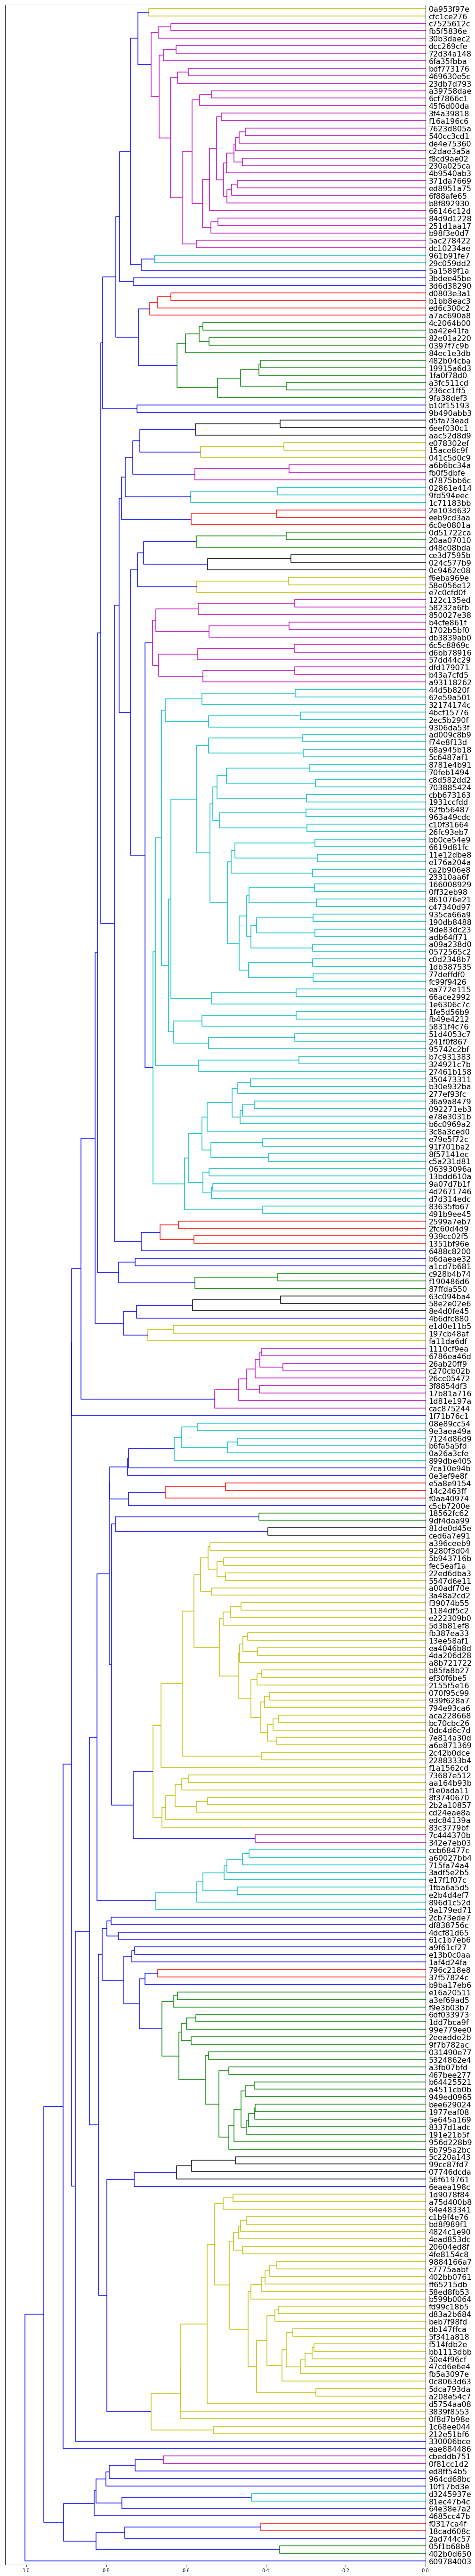

In [25]:
corr = np.round(scipy.stats.spearmanr(X_train_sub).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,100))
dendrogram = hc.dendrogram(z, labels=X_train_sub.columns, orientation='left', leaf_font_size=16)
plt.show()

# Predict and Submit

In [355]:
test_df_sub = test_df[to_keep].copy()
pred = rf.predict(test_df_sub)
pred = np.expm1(pred)

In [356]:
os.makedirs('submissions', exist_ok=True)
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred
sub_df.to_csv("submissions/v02_RF_FI.csv", index=False)